In [1]:
import tools
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


True

In [2]:
import os
import os
from langchain.chat_models import init_chat_model



llm = init_chat_model(
    "azure_openai:gpt-4.1-mini",
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    api_version="2024-12-01-preview"
)


agent_tools = [tools.get_all_plants, tools.get_bloom_data]
llm_with_tools = llm.bind_tools(agent_tools)

In [3]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content=('Du bist ein Assistent, der Informationen über die Blütezeit von Pflanzen bereitstellt.'
                                 'Anweisungen:'
                                 '- Du bekommst eine Anfrage ob eine Pflanze ob eine schon blüht oder schon gebölüht hat'
                                 '- Nutze get_all_plants um eine Liste aller Pflanzen zu erhalten zu denen Daten existieren.'
                                 '- Prüfe ob die Pflanze aus der Anfrage in der Liste der Pflanzen enthalten ist.'
                                 '- Wenn die Pflanze nicht in der Liste ist, antworte mit: {"response": "no answer", "reasoning": "Die Pflanze ist nicht in der Liste der bekannten Pflanzen."}'
                                 '- Dann nutze get_bloom_data mit der angefragten Pflanze, um Informationen über die Blütezeit zu erhalten. '
                                 'Antworte in JSON und folge dem Schema: {"type": "object","properties": {"response": {"type": "string","enum": ["yes", "no", "no answer"]},reasoning": {"type": "string"}},"required": ["response", "reasoning"]}'
                                 'response soll auf "yes" gesetzt werden, wenn die Pflanze blüht und "no", wenn sie nicht blüht. Falls die Pflanze nicht in der Liste ist, setze response auf "no answer".'
                        ))

# Node
def agent(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

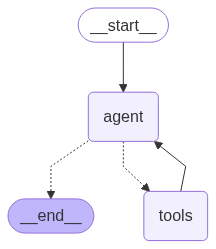

In [4]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("agent", agent)
builder.add_node("tools", ToolNode(agent_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "agent")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


In [5]:
messages = [HumanMessage(content="Angenommen heute wäre der 01.06.2020. Wir sind in Berlin. Hat die Erle schon angefangen zu blühen?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Angenommen heute wäre der 01.06.2020. Wir sind in Berlin. Hat die Erle schon angefangen zu blühen?
================================== Ai Message ==================================
Tool Calls:
  get_all_plants (call_9gfUB12OjKRqlonZ8d1U5ptD)
 Call ID: call_9gfUB12OjKRqlonZ8d1U5ptD
  Args:
================================= Tool Message =================================
Name: get_all_plants

apfel birke erle hasel winterraps winterroggen esche forsythie huflattich loewenzahn schneegloeckhen beifuss
================================== Ai Message ==================================
Tool Calls:
  get_bloom_data (call_WeSo85DY4l9W4Xv3GS6n4RqZ)
 Call ID: call_WeSo85DY4l9W4Xv3GS6n4RqZ
  Args:
    plant: erle
    year: 2020
================================= Tool Message =================================
Name: get_bloom_data

{"data": {"Jahr": {"5": 2020}, "Gebietsmittel": {"5": "12.02. "}, "Abweichung vom Mittel": {"

In [6]:
import json
from utils import get_tokens
import sys
#base_prompt = 'Antworte in JSON und folge dem Schema: { "type": "object", "properties": { "response": { "type": "boolean" }, "reasoning": { "type": "string" } }, "required": [ "response", "reasoning" ] }'
with open("datasets/dataset_850.json", "r") as file:
    dataset = json.load(file)


responses = []
count = 0
for data in dataset:
    sentence = data["sentence"]
    prompt = [HumanMessage(content=sentence)]
    print(f"Processing: {sentence}")
    try:
        messages = react_graph.invoke({"messages": prompt})
        for m in messages['messages']:
            m.pretty_print()
        response = messages["messages"][-1].content
        cleaned_response = response.strip("```json").strip("```").strip()
        response_json = json.loads(cleaned_response)
        tokens = get_tokens(messages)
        responses.append({
            "id": data["id"],
            "plant": data["plant"],
            "city": data["city"],
            "date": data["date"],
            "sentence": sentence,
            "response": response_json["response"],
            "reasoning": response_json["reasoning"],
            "tokens": tokens
        })
    except Exception as e:
        print(f"Error processing {sentence}: {e}")
        responses.append({
            "id": data["id"],
            "plant": data["plant"],
            "city": data["city"],
            "date": data["date"],
            "sentence": sentence,
            "response": "error",
            "reasoning": str(e),
            "tokens": 0
        })
    count += 1
    print("Processed:", count, "/", len(dataset), "responses collected:", len(responses))
    

#print(responses)

with open("results/single_agent_850.json", "w") as file:
    json.dump(responses, file, indent=4)

Processing: Haben sich bis 29.04.2021 in Nürnberg bereits Blüten an der Apfel gezeigt?
================================ Human Message =================================

Haben sich bis 29.04.2021 in Nürnberg bereits Blüten an der Apfel gezeigt?
================================== Ai Message ==================================
Tool Calls:
  get_all_plants (call_TpPAUt0RjPGNXq1SoZnRlfWO)
 Call ID: call_TpPAUt0RjPGNXq1SoZnRlfWO
  Args:
  get_bloom_data (call_1i168tcBFncOIZyNJrDnlSj9)
 Call ID: call_1i168tcBFncOIZyNJrDnlSj9
  Args:
    plant: Apfel
    year: 2021
================================= Tool Message =================================
Name: get_all_plants

apfel birke erle hasel winterraps winterroggen esche forsythie huflattich loewenzahn schneegloeckhen beifuss
================================= Tool Message =================================
Name: get_bloom_data

{"data": {"Jahr": {"4": 2021}, "Gebietsmittel": {"4": "01.05. "}, "Abweichung vom Mittel": {"4": "5 Tage"}}, "info": "Tabe

In [7]:
%load_ext autoreload
%autoreload 2

flower = tools.Flower("erle")
#flower = flower[flower.begin_data["Jahr"] == 2020]
flower.begin_data["Jahr"]

tools.get_bloom_data("erle", 2020, "beginn")

TypeError: get_bloom_data() takes 2 positional arguments but 3 were given